Importamos las librerias. Algunas son para el uso de la GPU, otras son para el proyecto

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from PIL import Image
import subprocess



2024-04-26 09:50:40.675835: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 09:50:40.675864: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 09:50:40.676788: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-26 09:50:40.682244: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 09:50:41.368953: W tensorflow/compiler/tf2

Para que el programa utilice la VRAM que tiene el sistema y no la RAM de la computadora

In [2]:
def get_gpu_memory():
    """Returns the total memory of the GPU in MB"""
    try:
        result = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=memory.total", "--format=csv,nounits,noheader"], 
            encoding='utf-8')
        return int(result.strip())
    except Exception as e:
        print("Error al obtener la información de la memoria de la GPU:", e)
        return None

# Obtener la cantidad de memoria VRAM disponible en la GPU
total_memory_mb = get_gpu_memory()
if total_memory_mb is not None:
    total_memory_gb = total_memory_mb / 1024
    print("Cantidad total de memoria VRAM en la GPU:", total_memory_gb, "GB")
    
    # Configurar TensorFlow para limitar el uso de memoria GPU
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            # Limitar la memoria GPU al máximo disponible
            tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No se pudo obtener la información de la memoria de la GPU.")

Cantidad total de memoria VRAM en la GPU: 6.0 GB


2024-04-26 09:50:42.254593: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-26 09:50:42.287045: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-26 09:50:42.287297: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Leer la base de datos creada con anterioridad y ver su contenido

In [3]:
df = pd.read_hdf('BD_Emotios_240324.h5')

In [4]:
df.head()

,Imagen,Caracteristicas,Rostro,Etiqueta
0,"[[[154, 163, 162], [154, 163, 162], [154, 163,...","[[[46, 79], [46, 86], [46, 94], [47, 101], [49...","[[[31, 32, 37], [39, 39, 43], [37, 37, 39], [3...",relaxed
1,"[[[164, 178, 179], [164, 178, 178], [164, 178,...","[[[62, 46], [62, 53], [63, 59], [64, 65], [66,...","[[[27, 28, 31], [21, 22, 22], [39, 39, 41], [7...",relaxed
2,"[[[152, 161, 160], [153, 162, 161], [153, 162,...","[[[41, 79], [40, 87], [40, 94], [42, 102], [44...","[[[32, 32, 32], [23, 23, 23], [19, 19, 21], [2...",relaxed
3,"[[[153, 161, 163], [153, 162, 161], [152, 162,...","[[[46, 79], [46, 87], [47, 95], [48, 103], [51...","[[[153, 163, 164], [154, 164, 165], [153, 163,...",relaxed
4,"[[[152, 161, 162], [152, 161, 160], [152, 162,...","[[[45, 79], [45, 86], [46, 94], [47, 102], [49...","[[[75, 84, 86], [36, 37, 39], [31, 31, 31], [2...",relaxed


Verificar que no sea irregular de imagen y rostro

In [5]:
print(df['Imagen'].shape)
print(df['Rostro'].shape)

(5037,)
(5037,)


Separamos las caracteristicas y etiquetas

In [6]:
# Separar las características y etiquetas
X = np.array(df['Rostro'])
y = df['Etiqueta']

Verificamos el formato, que sea ideal para la CNN

In [8]:
print(df['Imagen'].values[0].shape)
print(df['Rostro'].values[1].shape)

print(X[0].shape)

(150, 150, 3)
(43, 44, 3)
(51, 52, 3)


Dado que el formato de rostro puede ser menor o mayor medida, hay que adaptar todos los datos a un formato. En este caso lo escalamos a 150x150

In [9]:
for i in range(X.shape[0]):
    X[i] = np.array(Image.fromarray(X[i]).resize((150,150)))

Verificamos el formato 

In [10]:
print(X[0].shape)

(150, 150, 3)


Codificamos el formato de las etiquetas para que estén en 0,1,2,3,4,5...

In [12]:
# Codificar las etiquetas
etiquetas = y.unique()
y_encoded = pd.Categorical(y, categories=etiquetas).codes

Verificamos que se haya transformado a un formato minimo y maximo

In [13]:
print(y_encoded)

[0 0 0 ... 5 5 5]


Hacemos los datos de entrenamiento y los de prueba

In [14]:
# Dividir el dataset en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


Transformar las etiquetas a one_hot. Dependiendo la posición del numero es la etiqueta 

In [23]:
# Convertir las etiquetas a formato one-hot
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)

In [24]:
print(y_val_one_hot)
print("Clases originales:", df['Etiqueta'].unique())

[[0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]]
Clases originales: ['relaxed' 'bored' 'interested' 'excited' 'engaged' 'focused']


Distribución visual de las etiquetas y su clasificacion

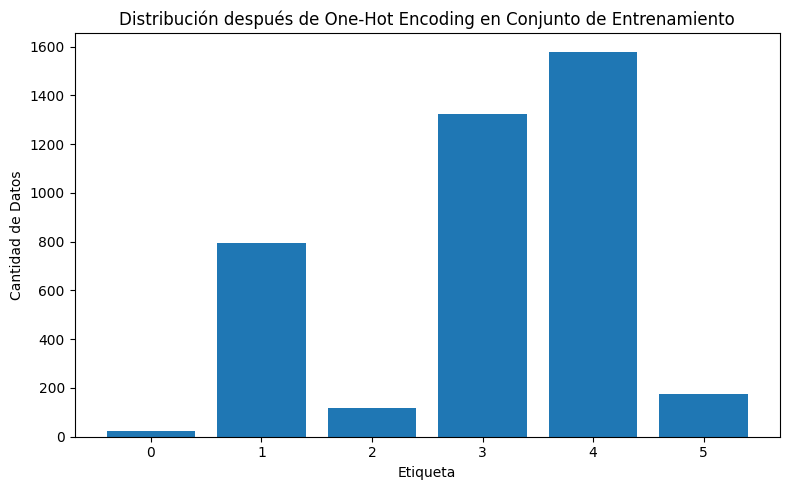

In [25]:
# Visualizar la distribución después de convertir las etiquetas a one-hot
plt.figure(figsize=(8, 5))
plt.bar(np.unique(y_train_one_hot.argmax(axis=1)), np.bincount(y_train_one_hot.argmax(axis=1)), align='center')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad de Datos')
plt.title('Distribución después de One-Hot Encoding en Conjunto de Entrenamiento')
plt.tight_layout()
plt.show()

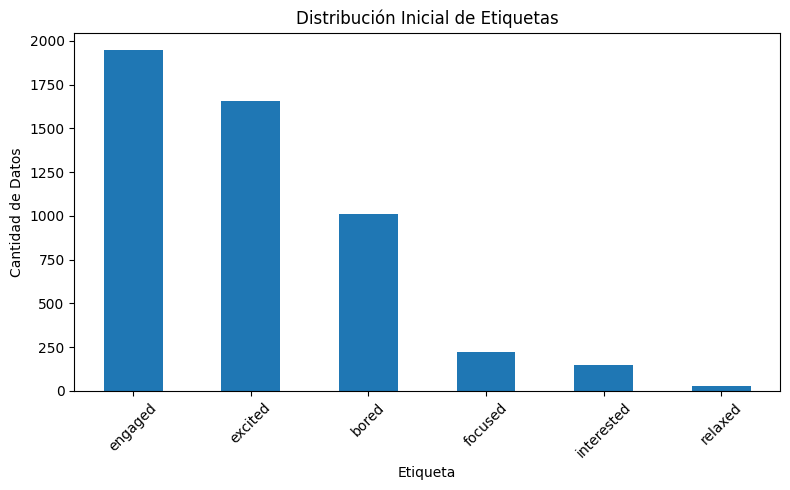

In [26]:
# Visualizar la distribución inicial de etiquetas
plt.figure(figsize=(8, 5))
df['Etiqueta'].value_counts().plot(kind='bar')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad de Datos')
plt.title('Distribución Inicial de Etiquetas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Normalizamos los datos de entrenamiento y los de valores para verificar en numpy array

In [28]:
# Convertir las imágenes a arrays numpy y normalizarlas
X_train = np.array([np.array(img) for img in X_train])
X_val = np.array([np.array(img) for img in X_val])

Todos los datos de entrenamiento los ponemos en tipo flotante 32 y lo dividimos en 255 (que es formato de imagen), esto para normalizar del 0 al 1

In [29]:
# Normalizar las imágenes dividiendo por 255.0
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

ValueError: setting an array element with a sequence.

Generamos infinidad de imagenes (Muchas imagenes. No son infinitas). Definimos los patrones para generar más imagenes y que el modelo no se sobre ajuste

In [ ]:
# Definir el generador de imágenes para aumentar el dataset de entrenamiento
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Aqui lo aumentamos.

In [ ]:
# Aumentar el dataset de entrenamiento utilizando el generador de imágenes
train_generator = datagen.flow(X_train, y_train_one_hot, batch_size=32)


Todo el modelo definido

In [ ]:
# Definir el modelo de red neuronal convolucional (CNN)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(etiquetas), activation='softmax')  # Capa de salida con activación softmax
])


2024-04-24 20:06:53.904374: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-24 20:06:53.904905: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-24 20:06:53.905281: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Compilamos el modelo.

In [ ]:
# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Entrenamos el modelo

In [ ]:
# Entrenar el modelo con el callback de TensorBoard
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=(X_val, y_val_one_hot),
                    verbose=1,
                    )


Epoch 1/10


2024-04-24 20:06:55.236083: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-24 20:06:57.527127: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f1379199c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-24 20:06:57.527148: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti with Max-Q Design, Compute Capability 7.5
2024-04-24 20:06:57.549435: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1714014417.683895   32174 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


126/126 [==============================] - 21s 129ms/step - loss: 1.0112 - accuracy: 0.5254 - val_loss: 0.8834 - val_accuracy: 0.5476
Epoch 2/10
126/126 [==============================] - 15s 117ms/step - loss: 0.8857 - accuracy: 0.5967 - val_loss: 0.8193 - val_accuracy: 0.6161
Epoch 3/10
126/126 [==============================] - 16s 129ms/step - loss: 0.8744 - accuracy: 0.6026 - val_loss: 0.8114 - val_accuracy: 0.6250
Epoch 4/10
126/126 [==============================] - 15s 117ms/step - loss: 0.8541 - accuracy: 0.6031 - val_loss: 0.8097 - val_accuracy: 0.6409
Epoch 5/10
126/126 [==============================] - 16s 125ms/step - loss: 0.8379 - accuracy: 0.6287 - val_loss: 0.8086 - val_accuracy: 0.6389
Epoch 6/10
126/126 [==============================] - 15s 122ms/step - loss: 0.8544 - accuracy: 0.6200 - val_loss: 0.7841 - val_accuracy: 0.6468
Epoch 7/10
126/126 [==============================] - 16s 126ms/step - loss: 0.8265 - accuracy: 0.6287 - val_loss: 0.7918 - val_accuracy: 0.6

Guardamos el modelo

In [ ]:
# Guardar el modelo
model.save('modelo_cnn_gray.h5')

/home/waldos/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Obtenemos predicciones del conjunto de validacion

In [ ]:
# Obtener las predicciones del conjunto de validación
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

32/32 [==============================] - 0s 7ms/step


Tabla graficamente de la precision y perdida del modelo a partir de las epocas

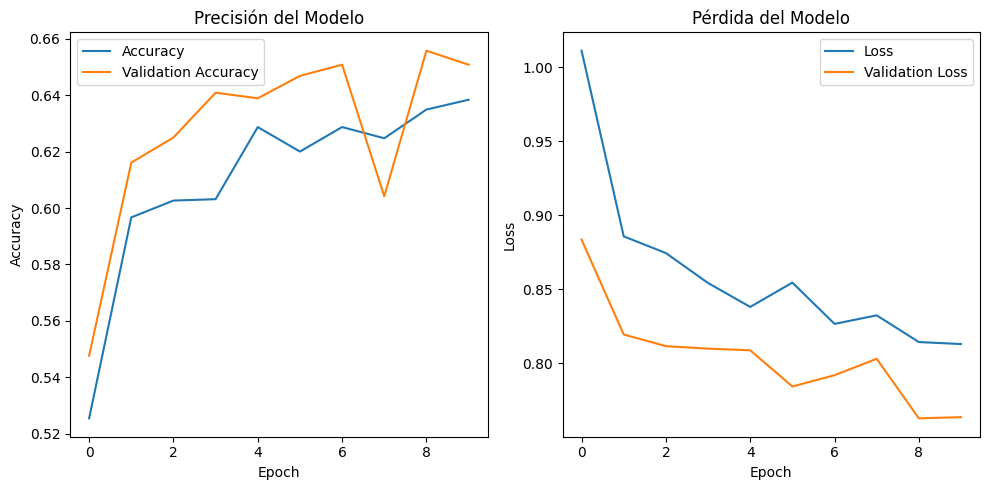

In [ ]:
# Mostrar la precisión y pérdida del modelo
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Precisión del Modelo')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Pérdida del Modelo')

plt.tight_layout()
plt.show()

Matriz de confusion

In [ ]:
# Calcular la matriz de confusión
conf_mat = confusion_matrix(np.argmax(y_val_one_hot, axis=1), y_pred_classes)

Visualizacion de la matriz de confusion mediante mapa de calor

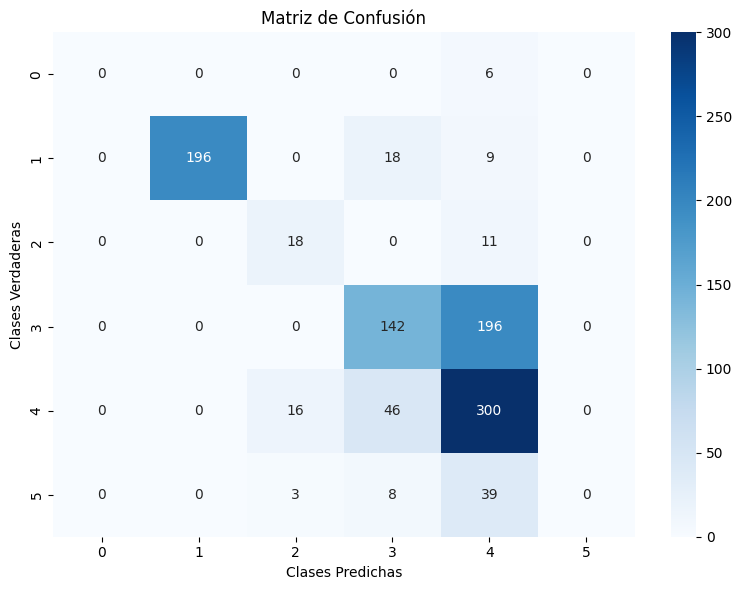

In [ ]:
# Visualizar la matriz de confusión como un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Verdaderas')
plt.title('Matriz de Confusión')
plt.tight_layout()
plt.show()